In [ ]:
!pip install torchdiffeq

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

We define here the useful functions and class for the interpolant method explained in the previous notebook applied to the 2D case.

In [ ]:
import torch
from torchdiffeq import odeint_adjoint as odeint
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import sys
def make_It(path='linear', gamma = None, gamma_dot = None, gg_dot = None):
    """gamma function must be specified if using the trigonometric interpolant"""

    if path == 'linear':

        a      = lambda t: (1-t)
        adot   = lambda t: -1.0
        b      = lambda t: t
        bdot   = lambda t: 1.0
        It   = lambda t, x0, x1: a(t)*x0 + b(t)*x1
        dtIt = lambda t, x0, x1: adot(t)*x0 + bdot(t)*x1

    elif path == 'trig':
        if gamma == None:
            raise TypeError("Gamma function must be provided for trigonometric interpolant!")
        a    = lambda t: torch.sqrt(1 - gamma(t)**2)*torch.cos(0.5*math.pi*t)
        b    = lambda t: torch.sqrt(1 - gamma(t)**2)*torch.sin(0.5*math.pi*t)
        adot = lambda t: -gg_dot(t)/torch.sqrt(1 - gamma(t)**2)*torch.cos(0.5*math.pi*t) \
                                - 0.5*math.pi*torch.sqrt(1 - gamma(t)**2)*torch.sin(0.5*math.pi*t)
        bdot = lambda t: -gg_dot(t)/torch.sqrt(1 - gamma(t)**2)*torch.sin(0.5*math.pi*t) \
                                + 0.5*math.pi*torch.sqrt(1 - gamma(t)**2)*torch.cos(0.5*math.pi*t)

        It   = lambda t, x0, x1: a(t)*x0 + b(t)*x1
        dtIt = lambda t, x0, x1: adot(t)*x0 + bdot(t)*x1

    elif path == 'encoding-decoding':

        a    = lambda t: torch.where(t <= 0.5, torch.cos(math.pi*t)**2, torch.tensor(0.))
        adot = lambda t: torch.where(t <= 0.5, -2*math.pi*torch.cos(math.pi*t)*torch.sin(math.pi*t), torch.tensor(0.))
        b    = lambda t: torch.where(t > 0.5,  torch.cos(math.pi*t)**2, 0.)
        bdot = lambda t: torch.where(t > 0.5,  -2*math.pi*torch.cos(math.pi*t)*torch.sin(math.pi*t), torch.tensor(0.))
        It   = lambda t, x0, x1: a(t)*x0 + b(t)*x1
        dtIt = lambda t, x0, x1: adot(t)*x0 + bdot(t)*x1

    elif path == 'one-sided-linear':

        a      = lambda t: (1-t)
        adot   = lambda t: -1.0
        b      = lambda t: t
        bdot   = lambda t: 1.0

        It   = lambda t, x0, x1: a(t)*x0 + b(t)*x1
        dtIt = lambda t, x0, x1: adot(t)*x0 + bdot(t)*x1

    elif path == 'one-sided-trig':

        a      = lambda t: torch.cos(0.5*math.pi*t)
        adot   = lambda t: -0.5*math.pi*torch.sin(0.5*math.pi*t)
        b      = lambda t: torch.sin(0.5*math.pi*t)
        bdot   = lambda t: 0.5*math.pi*torch.cos(0.5*math.pi*t)


        It   = lambda t, x0, x1: a(t)*x0 + b(t)*x1
        dtIt = lambda t, x0, x1: adot(t)*x0 + bdot(t)*x1

    elif path == 'mirror':
        if gamma == None:
            raise TypeError("Gamma function must be provided for mirror interpolant!")

        a     = lambda t: gamma(t)
        adot  = lambda t: gamma_dot(t)
        b     = lambda t: torch.tensor(1.0)
        bdot  = lambda t: torch.tensor(0.0)

        It    = lambda t, x0, x1: b(t)*x1 + a(t)*x0
        dtIt  = lambda t, x0, x1: adot(t)*x0

    elif path == 'custom':
        return None, None, None

    else:
        raise NotImplementedError("The interpolant you specified is not implemented.")


    return It, dtIt, (a, adot, b, bdot)


def make_gamma(gamma_type = 'brownian', aval = None):
    """
    returns callable functions for gamma, gamma_dot,
    and gamma(t)*gamma_dot(t) to avoid numerical divide by 0s,
    e.g. if one is using the brownian (default) gamma.
    """
    if gamma_type == 'brownian':
        gamma = lambda t: torch.sqrt(t*(1-t))
        gamma_dot = lambda t: (1/(2*torch.sqrt(t*(1-t)))) * (1 -2*t)
        gg_dot = lambda t: (1/2)*(1-2*t)

    elif gamma_type == 'a-brownian':
        gamma = lambda t: torch.sqrt(a*t*(1-t))
        gamma_dot = lambda t: (1/(2*torch.sqrt(a*t*(1-t)))) * a*(1 -2*t)
        gg_dot = lambda t: (a/2)*(1-2*t)

    elif gamma_type == 'zero':
        gamma = gamma_dot = gg_dot = lambda t: torch.zeros_like(t)

    elif gamma_type == 'bsquared':
        gamma = lambda t: t*(1-t)
        gamma_dot = lambda t: 1 -2*t
        gg_dot = lambda t: gamma(t)*gamma_dot(t)

    elif gamma_type == 'sinesquared':
        gamma = lambda t: torch.sin(math.pi * t)**2
        gamma_dot = lambda t: 2*math.pi*torch.sin(math.pi * t)*torch.cos(math.pi*t)
        gg_dot = lambda t: gamma(t)*gamma_dot(t)

    elif gamma_type == 'sigmoid':
        f = torch.tensor(10.0)
        gamma = lambda t: torch.sigmoid(f*(t-(1/2)) + 1) - torch.sigmoid(f*(t-(1/2)) - 1) - torch.sigmoid((-f/2) + 1) + torch.sigmoid((-f/2) - 1)
        gamma_dot = lambda t: (-f)*( 1 - torch.sigmoid(-1 + f*(t - (1/2))) )*torch.sigmoid(-1 + f*(t - (1/2)))  + f*(1 - torch.sigmoid(1 + f*(t - (1/2)))  )*torch.sigmoid(1 + f*(t - (1/2)))
        gg_dot = lambda t: gamma(t)*gamma_dot(t)

    elif gamma_type == None:
        gamma     = lambda t: torch.zeros(1) ### no gamma
        gamma_dot = lambda t: torch.zeros(1) ### no gamma
        gg_dot    = lambda t: torch.zeros(1) ### no gamma

    else:
        raise NotImplementedError("The gamma you specified is not implemented.")


    return gamma, gamma_dot, gg_dot

class Interpolant(torch.nn.Module):
    """
    Class for all things interpoalnt $x_t = I_t(x_0, x_1) + \gamma(t)z.
    If path is one-sided, then interpolant constructs x_t = a(t) x_0 + b(t) x_1 with x_0 ~ N(0,1).

    path: str,    what type of interpolant to use, e.g. 'linear' for linear interpolant. see fabrics for options
    gamma_type:   what type of gamma function to use, e.g. 'brownian' for $\gamma(t) = \sqrt{t(1-t)}
    """
    def __init__(self, path, gamma_type,gamma= None,gamma_dot = None,gg_dot= None,It = None, dtIt= None):
        super(Interpolant, self).__init__()


        self.path = path
        if gamma == None:
            if self.path == 'one-sided-linear' or self.path == 'one-sided-trig':
              gamma_type = None

            self.gamma, self.gamma_dot, self.gg_dot = make_gamma(gamma_type=gamma_type)

        else:
            self.gamma, self.gamma_dot, self.gg_dot = gamma, gamma_dot, gg_dot

        if self.path == 'custom':
            print('Assuming interpolant was passed in directly...')
            self.It = It
            self.dtIt = dtIt
            assert self.It != None
            assert self.dtIt != None


        self.It, self.dtIt, ab = make_It(path, self.gamma, self.gamma_dot, self.gg_dot)
        self.a, self.adot, self.b, self.bdot = ab[0], ab[1], ab[2], ab[3]


    def calc_xt(self, t, x0, x1):
        if self.path =='one-sided-linear' or self.path == 'mirror' or self.path=='one-sided-trig':
            return self.It(t, x0, x1)
        else:
            z = torch.randn(x0.shape).to(t)
            return self.It(t, x0, x1) + self.gamma(t)*z, z


We define the many losses we can have. We need a losses for each functions we want to estimate ( velocity, score, denoiser) and also the path 'one-sided-linear' require a special loss because some simplifications in the formula occur.

In [ ]:
def loss_per_sample_b(b, x0, x1, t, interpolant):
    """Compute the (variance-reduced) loss on an individual sample via antithetic sampling."""

    xt, z = interpolant.calc_xt(t, x0, x1)
    xt = xt.unsqueeze(0)
    dtIt        = interpolant.dtIt(t, x0, x1)
    gamma_dot   = interpolant.gamma_dot(t)
    bt         = b(xt, t)
    loss        = 0.5*torch.sum(bt**2) - torch.sum((dtIt + gamma_dot*z) * bt)
    return loss

def loss_per_sample_b_one_sided(b, x0, x1, t, interpolant):
    """Compute the (variance-reduced) loss on an individual sample via antithetic sampling."""

    xt = interpolant.calc_xt(t, x0, x1)
    xt, t = xt.unsqueeze(0), t.unsqueeze(0)
    dtIt        = interpolant.dtIt(t, x0, x1)
    gamma_dot   = interpolant.gamma_dot(t)
    bt         = b(xt, t)
    loss        = 0.5*torch.sum(bt**2) - torch.sum((dtIt) * bt)
    return loss

def loss_per_sample_s(
    s, x0, x1, t, interpolant
):
    """Compute the (variance-reduced) loss on an individual sample via antithetic sampling."""
    xt ,z = interpolant.calc_xt(t, x0, x1)
    xt ,t = xt.unsqueeze(0), t.unsqueeze(0)
    st = s(xt, t)
    loss = 0.5 * torch.sum(st**2) + (1 / interpolant.gamma(t)) * torch.sum(st * z)
    return loss

def loss_per_sample_eta(
    eta, x0, x1, t, interpolant
):
    """Compute the loss on an individual sample via antithetic sampling."""
    xt, z = interpolant.calc_xt(t, x0, x1)
    xt, t = xt.unsqueeze(0), t.unsqueeze(0)
    eta_val = eta(xt, t)
    return 0.5 * torch.sum(eta_val**2) + torch.sum(eta_val * z)


def loss_per_sample_one_sided_s(
    s, x0, x1, t, interpolant
):
    """Compute the loss on an individual sample via antithetic samples for x_t = sqrt(1-t)z + sqrt(t) x1 where z=x0."""
    xt = interpolant.calc_xt(t, x0, x1)
    xt, t = xt.unsqueeze(0), t.unsqueeze(0)
    st = s(xt, t)
    alpha = interpolant.a(t)
    loss = 0.5 * torch.sum(st**2) + (1 / alpha) * torch.sum(st * x0)
    return loss

def loss_per_sample_one_sided_eta(
    eta, x0, x1, t, interpolant
):
    """Compute the loss on an individual sample via samples for x_t = alpha(t)z + beta(t) x1 where z=x0."""
    xt = interpolant.calc_xt(t, x0, x1)
    xt, t = xt.unsqueeze(0), t.unsqueeze(0)
    etat = eta(xt, t)
    loss = 0.5 * torch.sum(etat**2) + torch.sum(etat * x0)
    return loss


def make_loss(loss, bvseta, x0,x1, t, interpolant):
    """Convert a sample loss into a batched loss."""
    ## Share the batch dimension i for x0, x1, t
    in_dims_set = (None, 0, 0, 0, None)
    batched_loss = torch.vmap(loss, in_dims=in_dims_set, randomness='different')
    loss_val = batched_loss(bvseta, x0, x1, t, interpolant)
    loss_val = loss_val.mean()
    return loss_val





In [ ]:
# class for SDE sampling.
class SDEIntegrator(torch.nn.Module):
    def __init__(self, b, s = None,eps=torch.tensor(0),interpolant=None,n_save=4,start_end = (0, 1), n_step = 100):
        super(SDEIntegrator, self).__init__()
        self.b =b
        self.s=s
        self.eps = eps
        self.n_save = n_save
        self.n_step = n_step
        self.start_end = start_end
        self.start, self.end = self.start_end
        self.ts = torch.linspace(self.start, self.end, self.n_step)
        self.dt = self.ts[1] - self.ts[0]
        self.interpolant = interpolant
        if self.s is None or self.eps == 0:
            self.bf = self.b
        else:
            self.bf = lambda x, t: self.b(x, t) + self.eps * self.s(x, t)




    def step_forward_heun(self, x: torch.tensor, t: torch.tensor) -> torch.tensor:
        """Heun Step -- see https://arxiv.org/pdf/2206.00364.pdf, Alg. 2"""
        dW = torch.sqrt(self.dt) * torch.randn_like(x)
        xhat = x + torch.sqrt(2 * self.eps) * dW
        K1 = self.bf(xhat, t + self.dt)
        xp = xhat + self.dt * K1
        K2 = self.bf(xp, t + self.dt)
        return xhat + 0.5 * self.dt * (K1 + K2)

    def step_forward(self, x: torch.tensor, t: torch.tensor) -> torch.tensor:
        """Euler-Maruyama."""
        dW = torch.sqrt(self.dt) * torch.randn_like(x)
        return x + self.bf(x, t) * self.dt + torch.sqrt(2 * self.eps) * dW

    def rollout_forward(self, init: torch.tensor, method: str = 'heun') -> torch.tensor:
        """Solve the forward-time SDE to generate a batch of samples."""
        save_every = int(self.n_step / self.n_save)
        xs = torch.zeros((self.n_save, *init.shape)).to(init.device)
        x = init
        self.dt = self.dt.to(init.device)

        save_counter = 0

        for ii, t in enumerate(self.ts[:-1]):
            t = t.to(init.device).unsqueeze(0)
            if method == 'heun':
                x = self.step_forward_heun(x, t)
            else:
                x = self.step_forward(x, t)

            if (ii + 1) % save_every == 0:
                xs[save_counter] = x
                save_counter += 1

        xs[save_counter] = x

        return xs


class SFromEta(torch.nn.Module):
    """Class for turning a noise model into a score model."""
    def __init__(
        self,
        eta,
        gamma,
    ) -> None:
        super(SFromEta, self).__init__()
        self.eta = eta
        self.gamma = gamma

    def forward(self, x, t):
        val = (self.eta(x,t) / self.gamma(t))
        return val

def grab(var):
    return var.detach().cpu().numpy()


# Functions and class for ODE sampling.
def compute_div(f,x,t):
    """Compute the divergence of f(x,t) with respect to x, assuming that x is batched. Assumes data is [bs, d]"""
    bs = x.shape[0]
    with torch.set_grad_enabled(True):
        x.requires_grad_(True)
        t.requires_grad_(True)
        f_val = f(x, t)
        divergence = 0.0
        for i in range(x.shape[1]):
            divergence += \
                    torch.autograd.grad(
                            f_val[:, i].sum(), x, create_graph=True
                        )[0][:, i]

    return divergence.view(bs)


class PFlowRHS(torch.nn.Module):
    def __init__(self, b, interpolant, sample_only=False):
        super(PFlowRHS, self).__init__()
        self.b = b
        self.interpolant = interpolant
        self.sample_only = sample_only


    def setup_rhs(self):
        def rhs(x: torch.tensor, t: torch.tensor):
            self.b.to(x)

            t = t.unsqueeze(0)
            return self.b(x,t)

        self.rhs = rhs


    def forward(self, t, states):
        x = states[0]
        if self.sample_only:
            return (self.rhs(x, t), torch.zeros(x.shape[0]).to(x))
        else:
            return (self.rhs(x, t), -compute_div(self.rhs, x, t))

    def reverse(self, t: torch.tensor, states):
        x = states[0]
        if self.sample_only:
            return (-self.rhs(x, t), torch.zeros(x.shape[0]).to(x))
        else:
            return (-self.rhs(x, t), compute_div(self.rhs, x, t))

from dataclasses import dataclass
Velocity = torch.nn.Module

@dataclass
class PFlowIntegrator:
    b: Velocity
    method: str
    interpolant: Interpolant
    start_end: tuple = (0.0, 1.0)
    n_step: int = 5
    atol: torch.tensor = 1e-5
    rtol: torch.tensor = 1e-5
    sample_only: bool  = False
    mirror:      bool  = False


    def __post_init__(self) -> None:

        self.rhs = PFlowRHS(b=self.b, interpolant=self.interpolant, sample_only=self.sample_only)
        self.rhs.setup_rhs()

        self.start, self.end = self.start_end[0], self.start_end[1]


    def rollout(self, x0, reverse=False):
        if reverse:
            integration_times = torch.linspace(self.end, self.start, self.n_step).to(x0)
        else:
            integration_times = torch.linspace(self.start, self.end, self.n_step).to(x0)
        dlogp = torch.zeros(x0.shape[0]).to(x0)

        state = odeint(
            self.rhs,
            (x0, dlogp),
            integration_times,
            method=self.method,
            atol=[self.atol, self.atol],
            rtol=[self.rtol, self.rtol]
        )

        x, dlogp = state
        return x, dlogp


def grab(var):
    return var.detach().cpu().numpy()

We now define our model. We choose a Unet with simple time-embedding.

In [ ]:
# model from : https://yang-song.net/blog/2021/score/
import torch.nn as nn
class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps."""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.dense(x)[..., None, None]


class Unet(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""
    def __init__(self, color_channels = 1, channels=[32, 128, 256, 256], embed_dim=256):
        super().__init__()
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
                                   nn.Linear(embed_dim, embed_dim))
        self.act = lambda x: x * torch.sigmoid(x)

        # Encoding layers
        self.conv1 = nn.Conv2d(color_channels, channels[0], 3, stride=1, padding=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, padding=1, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, padding=1, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, padding=1, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], color_channels, 3, stride=1, padding=1)

    def forward(self, x, t):
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.embed(t))

        # Encoding path
        h1 = self.conv1(x)
        h1 += self.dense1(embed)
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)

        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)

        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)

        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)

        # Decoding path
        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)

        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)

        h = self.tconv1(torch.cat([h, h1], dim=1))

        return h

We now import the MNIST dataset and normalize the data.

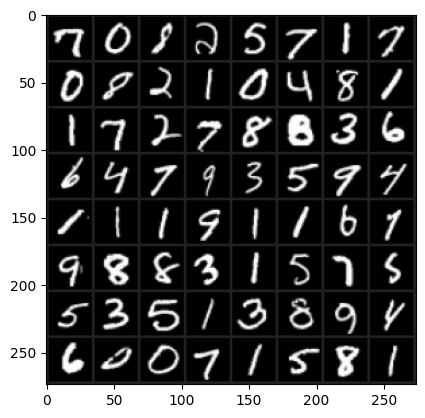

In [ ]:
import torch
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
batch_size = 64
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


def imshow(img):
    img = img * 0.3081 + 0.1307
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

data_iter = iter(train_loader)
images, labels = next(data_iter)

imshow(torchvision.utils.make_grid(images))


We can now train our model by training both eta and the velocity b.

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


base_lr = 1e-3
path = 'one-sided-linear'
interpolant  = Interpolant(path=path, gamma_type='')

b = Unet(color_channels = 1).to(device)
eta = Unet(color_channels = 1).to(device)

opt_b     = torch.optim.Adam(  b.parameters(), lr=base_lr)
opt_eta   = torch.optim.Adam(eta.parameters(), lr=base_lr)
sched_b   = torch.optim.lr_scheduler.StepLR(optimizer=  opt_b, step_size=1500, gamma=0.4)
sched_eta = torch.optim.lr_scheduler.StepLR(optimizer=opt_eta, step_size=1500, gamma=0.4)


epochs=50
n = len(train_loader)
for epoch in range(epochs):
    b.train()
    eta.train()
    epoch_loss = 0
    for x1, label in train_loader:
        x1 = x1.to(device)
        x0 = torch.randn_like(x1).to(device)
        ts  = torch.rand(size=(x1.shape[0],)).to(device)
        loss_b = make_loss(loss_per_sample_b_one_sided, b,  x0, x1, ts, interpolant)
        loss_eta = make_loss(loss_per_sample_one_sided_eta, eta, x0, x1, ts, interpolant)
        loss = loss_b + loss_eta
        epoch_loss += loss.item()/n
        opt_b.zero_grad()
        opt_eta.zero_grad()
        loss_b.backward()
        loss_eta.backward()
        opt_b.step()
        opt_eta.step()
        sched_b.step()
        sched_eta.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}')





Epoch 1/50, Loss: -1130.6074923818285
Epoch 2/50, Loss: -1281.8949201051091
Epoch 3/50, Loss: -1297.7969061032027
Epoch 4/50, Loss: -1306.865252594449
Epoch 5/50, Loss: -1312.1076346521447
Epoch 6/50, Loss: -1315.711653654508
Epoch 7/50, Loss: -1317.3982723537026
Epoch 8/50, Loss: -1318.4905139134123
Epoch 9/50, Loss: -1320.0184088017652
Epoch 10/50, Loss: -1319.5245470644845
Epoch 11/50, Loss: -1319.3031108669124
Epoch 12/50, Loss: -1319.6497952394136
Epoch 13/50, Loss: -1319.6203920409102


KeyboardInterrupt: 

We now can visualize our results using our models trained to estimate the velocity and the score and use the forward Fokker-Plank equation (SDE) to generate new samples.

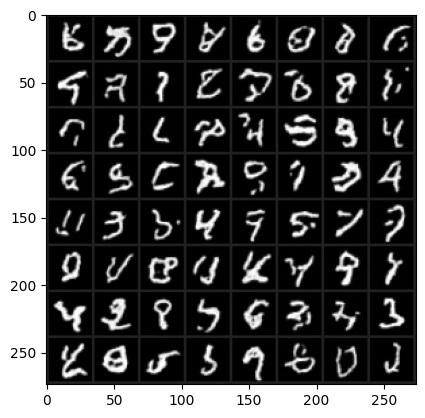

<Figure size 640x480 with 0 Axes>

In [ ]:
s = SFromEta(eta, interpolant.a)

sde_flow = SDEIntegrator(b=b, s=s, eps=torch.tensor(0.01), n_save=4, start_end=(0.0001, 0.999), n_step=10**3).to(device)
# pflow = PFlowIntegrator(b=b,  method='dopri5', interpolant=interpolant, n_step=3) ODE
bs = 64
with torch.no_grad():
    x0_tests  = torch.randn(bs,1, 32, 32).to(device)
    xfs_sde   = sde_flow.rollout_forward(x0_tests, 'heun')
    xf_sde    = grab(xfs_sde[-1].squeeze())
    xf_sde = xf_sde.reshape(64,1,32,32)
    imshow(torchvision.utils.make_grid(torch.tensor(xf_sde)))
    xf_sde = xf_sde.transpose(0, 2, 3, 1)
plt.tight_layout()
plt.show()